# Testing Multivariate Structure Models to Determine Node Causal Parents

In [2]:
import sys
sys.path.insert(0, '../..')

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange as tnrange

from cs330.data_generators.multivariate_categorical import MultiCategorical
from cs330.data_generators.causal_graph import CausalGraph
from cs330.models.causal_parent_multivariate_model import *

In [9]:
if False:
    N = 10
    M = 2

    # Create graph and data generator
    data_gen = MultiCategorical(N, M)
    data_gen.graph.B = np.array([
        [0, 0],
        [1, 0]
    ])

if True:
    N = 5
    M = 3

    data_gen = MultiCategorical(N, M)
    data_gen.graph.B = np.array([
        [0, 0, 0],
        [1, 0, 0],
        [1, 0, 0]
    ])

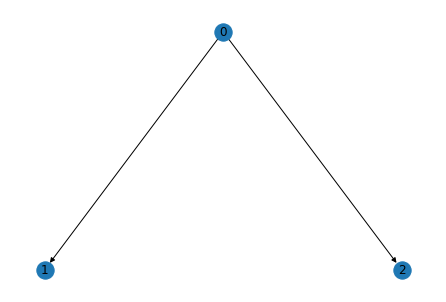

In [10]:
# Visualize Graph
data_gen.graph.visualize()

In [11]:
# Training Constants
inner_lr = 1e-3
outer_lr = 1e-2
transfer_episode_count = 200
transfer_episode_gradient_steps = 100
transfer_episode_batch_size = 250
pretrain_episode_gradient_steps = 100
pretrain_episode_batch_size = 500

hypothesis_sample_count = 20 # Number of hypotheses to sample for each structure update

In [7]:
'''
Create a causal parent multivariate model for the target node and data generator (including graph),
learn causal structure, and plot a graph of structure adaptation for each possible parent node.
'''
def structure_training(data_gen, target_node, num_runs=1):
    # Store structure training logs
    parent_likelihood_logs = torch.zeros(num_runs, transfer_episode_count + 1, M).detach()

    # Create model
    model = CausalParentMultivariateModel(N, M, target_node)
    hypothesis_opt = torch.optim.SGD(model.hypothesis_parameters(), lr=inner_lr)
    structure_opt = torch.optim.RMSprop(model.structure_parameters(), lr=outer_lr)

    for i in tnrange(num_runs, leave=False):
        # Sample a new distribution
        data_gen.reset_all_distributions()

        # Reset structure parameters
        model.reset_structure_parameters()

        # Log initial parent likelihoods
        parent_likelihood_logs[i, 0, :] = model.structure_likelihoods()

        # Pretrain model on base distribution
        # (Assume hypothesis where all other nodes are causal parents)
        pretrain_hypothesis = torch.ones(M)
        pretrain_hypothesis[target_node] = 0
        for grad_step in tnrange(pretrain_episode_gradient_steps, leave=False):
            # Sample from pretrain distribution
            pretrain_samples = data_gen.sample(pretrain_episode_batch_size)
        
            hypothesis_opt.zero_grad()
            logL = model.hypothesis_log_likelihood(pretrain_hypothesis, pretrain_samples)
            loss = -logL
            loss.backward()
            hypothesis_opt.step()
        model.save_pretrained_node_function()

        # Iterate through transfer episodes, updating structure params on each
        transfers = tnrange(transfer_episode_count, leave=False)
        for transfer_episode in transfers:
            # Sample a new transfer distribution (adjusting root node functions)
            data_gen.reset_root_distributions()

            # Iterate through sampled hypotheses
            hypothesis_list = torch.zeros((hypothesis_sample_count, M)).detach()
            hypothesis_online_logL = torch.zeros(hypothesis_sample_count).detach()
            for hypothesis_iter in range(hypothesis_sample_count):
                # Sample new hypothesis
                hypothesis = model.sample_hypothesis()

                # Accumulate log likelihood over training for this hypothesis
                online_logL = 0

                # Reset node function to pretrained state
                model.load_pretrained_node_function()

                # Train this hypothesis model
                for grad_step in range(transfer_episode_gradient_steps):
                    # Sample from transfer distribution
                    train_samples = data_gen.sample(transfer_episode_batch_size)

                    hypothesis_opt.zero_grad()
                    logL = model.hypothesis_log_likelihood(hypothesis, train_samples)
                    loss = -logL
                    loss.backward()
                    hypothesis_opt.step()

                    # Accumulate online log likelihood for this model
                    online_logL += logL.item()

                # Save results for this hypothesis
                hypothesis_list[hypothesis_iter] = hypothesis
                hypothesis_online_logL[hypothesis_iter] = online_logL

            # Update structure parameters
            structure_opt.zero_grad()
            model.compute_structure_gradients(hypothesis_list, hypothesis_online_logL)
            structure_opt.step()

            # Log structure params
            parent_likelihood_logs[i, transfer_episode + 1, :] = model.structure_likelihoods()

            # Add debug info to transfer episode progress bar
            transfers.set_postfix(parent_likelihoods=[round(l, 3) for l in model.structure_likelihoods().tolist()])

    # Plot structure parameter training progress
    fig, axarr = plt.subplots(M, 1, figsize=(9, 11), constrained_layout=True)
    fig.suptitle(f"Target Node: {target_node}")
    for parent_node in range(M):
        ax = axarr[parent_node]
        ax.title.set_text(f"Node {parent_node} -> Node {target_node}")
        for run in range(num_runs):
            ax.plot(parent_likelihood_logs[run, :, parent_node].detach().numpy())

        ax.tick_params(axis='both', which='major', labelsize=13)
        ax.axhline(1, c='lightgray', ls='--')
        ax.axhline(0, c='lightgray', ls='--')
        ax.set_xlim([0, transfer_episode_count])
        ax.set_xlabel('Number of episodes', fontsize=14)
        ax.set_ylabel("Hypothesis Likelihood", fontsize=14)
    plt.show()

In [8]:
for target_node in range(M):
    print(f"Target Node {target_node}")
    structure_training(data_gen, target_node, 4)

Target Node 0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

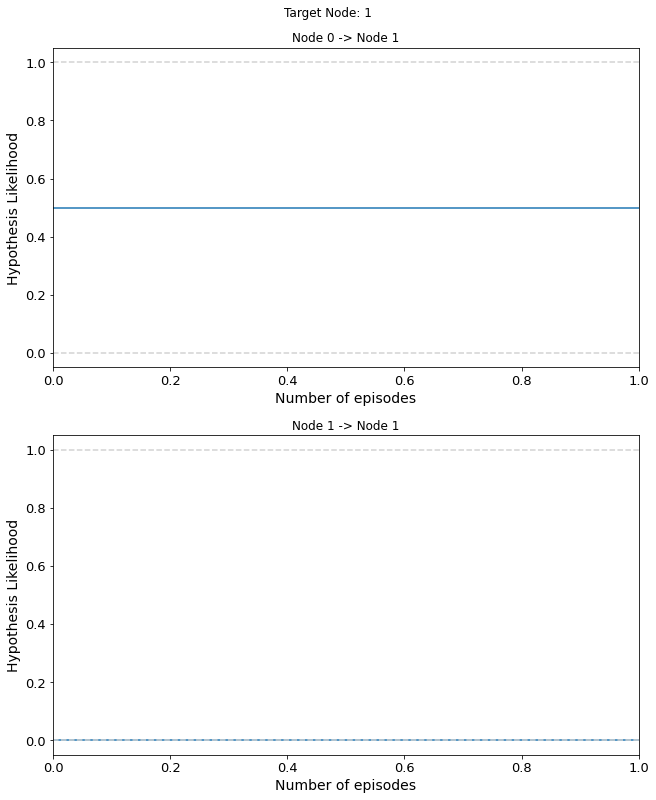

In [ ]:
structure_training(data_gen, 1)